In [1]:
from mpu6050 import mpu6050
from matplotlib import pyplot as plt
import json
import numpy as np
from ahrs.filters import Madgwick as ahrsMadgwick
from ahrs.filters import AQUA as ahrsAQUA
import numpy as np
import time
import math

def deg2rad(dat):
    return {'x': np.deg2rad(dat['x']), 'y': np.deg2rad(dat['y']), 'z': np.deg2rad(dat['z'])}
def dict2arr(dat):
    return [dat['x'], dat['y'], dat['z']]

def plot_raw(x, y):
    figure = plt.figure(figsize= (10, 5))
    plt.subplot(231)
    plt.plot(x, [el['a']['x'] for el in y], 'r')
    plt.plot(x, [0] * len(x), 'black')
    plt.subplot(232)
    plt.plot(x, [el['a']['y'] for el in y], 'g')
    plt.plot(x, [0] * len(x), 'black')
    plt.subplot(233)
    plt.plot(x, [el['a']['z'] for el in y], 'b')
    plt.plot(x, [9.8] * len(x), 'black')
    plt.subplot(234)
    plt.plot(x, [el['g']['x'] for el in y], 'r')
    plt.plot(x, [0] * len(x), 'black')
    plt.subplot(235)
    plt.plot(x, [el['g']['y'] for el in y], 'g')
    plt.plot(x, [0] * len(x), 'black')
    plt.subplot(236)
    plt.plot(x, [el['g']['z'] for el in y], 'b')
    plt.plot(x, [0] * len(x), 'black')
    plt.show()

def apply_madgwick(x, y, avgt):
    madgwick = ahrsMadgwick(q0 = np.tile([1., 0., 0., 0.], (1)), Dt = avgt, frequancy= avgt ** (-1),
                                    gyr= np.array([dict2arr(deg2rad(t['g'])) for t in y]),
                                    acc = np.array([dict2arr(t['a']) for t in y]),
                                    gain = 0.033)
    angles = []
    for q in madgwick.Q:
        # pitch = math.asin(-2.0*(q[1]*q[3] - q[0]*q[2]))
        # roll = math.atan2(2.0*(q[1]*q[2] + q[0]*q[3]), q[0]**2 + q[1]**2 - q[2]**2 - q[3]**2)
        ww = q[0]
        xx = q[1]
        yy = q[2]
        zz = q[3]
        t0 = +2.0 * (ww * xx + yy * zz)
        t1 = +1.0 - 2.0 * (xx * xx + yy * yy)
        roll = math.atan2(t0, t1)
     
        t2 = +2.0 * (ww * yy - zz * xx)
        t2 = +1.0 if t2 > +1.0 else t2
        t2 = -1.0 if t2 < -1.0 else t2
        pitch = math.asin(t2)
        angles.append({'pitch': math.degrees(pitch), 'roll': math.degrees(roll)})
        
    figure = plt.figure(figsize= (10, 5))
    plt.subplot(121)
    plt.plot(x, [el['roll'] for el in angles], 'r')
    plt.plot(x, [0] * len(x), 'black')
    plt.subplot(122)
    plt.plot(x, [el['pitch'] for el in angles], 'g')
    plt.plot(x, [0] * len(x), 'black')
    plt.show()

    for k in ['roll', 'pitch']:
        print(f"Avg {k}: ", sum([el[k] for el in angles])/len(x))
        print(f"Std {k}: ", np.std([el[k] for el in angles]), "\n")


def apply_aqua(x, y, avgt):
    aqua = ahrsAQUA(q0 = np.tile([1., 0., 0., 0.], (1)), Dt = avgt, frequancy= avgt ** (-1),
                        gyr= np.array([dict2arr(deg2rad(t['g'])) for t in y]), 
                        acc = np.array([dict2arr(t['a']) for t in y]),
                       alpha= 0.01, threshold= 0.9, adaptive= False)
    angles = []
    for q in aqua.Q:
        # pitch = math.asin(-2.0*(q[1]*q[3] - q[0]*q[2]))
        # roll = math.atan2(2.0*(q[1]*q[2] + q[0]*q[3]), q[0]**2 + q[1]**2 - q[2]**2 - q[3]**2)
        ww = q[0]
        xx = q[1]
        yy = q[2]
        zz = q[3]
        t0 = +2.0 * (ww * xx + yy * zz)
        t1 = +1.0 - 2.0 * (xx * xx + yy * yy)
        roll = math.atan2(t0, t1)
     
        t2 = +2.0 * (ww * yy - zz * xx)
        t2 = +1.0 if t2 > +1.0 else t2
        t2 = -1.0 if t2 < -1.0 else t2
        pitch = math.asin(t2)
        angles.append({'pitch': math.degrees(pitch), 'roll': math.degrees(roll)})
        
    figure = plt.figure(figsize= (10, 5))
    plt.subplot(121)
    plt.plot(x, [el['roll'] for el in angles], 'r')
    plt.plot(x, [0] * len(x), 'black')
    plt.subplot(122)
    plt.plot(x, [el['pitch'] for el in angles], 'g')
    plt.plot(x, [0] * len(x), 'black')
    plt.show()

    for k in ['roll', 'pitch']:
        print(f"Avg {k}: ", sum([el[k] for el in angles])/len(x))
        print(f"Std {k}: ", np.std([el[k] for el in angles]), "\n")
    


def apply_comp(x, y, avgt):
    angles = [{'roll': 0., 'pitch': 0}]
    for i in range(1, len(x)):
        # print("ggggg= ", (y[i]['g'])['y'] * avgt)
        pitch = (math.radians(angles[i-1]['pitch']) + deg2rad(y[i]['g'])['y'] * avgt) * 0.5 + (1 - 0.5) * (math.atan(-y[i]['a']['x'] / math.sqrt(y[i]['a']['y'] ** 2 + y[i]['a']['z'] ** 2)))
        roll = (math.radians(angles[i-1]['roll']) + deg2rad(y[i]['g'])['x'] * avgt) * 0.5 + (1-0.5) * math.atan(y[i]['a']['y'] / math.sqrt(y[i]['a']['x'] ** 2 + y[i]['a']['z'] ** 2))
        angles.append({"roll": math.degrees(roll), "pitch": math.degrees(pitch)})
        # print(angles[i])

    figure = plt.figure(figsize= (10, 5))
    plt.subplot(121)
    plt.plot(x, [el['roll'] for el in angles], 'r')
    plt.plot(x, [0] * len(x), 'black')
    plt.subplot(122)
    plt.plot(x, [el['pitch'] for el in angles], 'g')
    plt.plot(x, [0] * len(x), 'black')
    plt.show()

    for k in ['roll', 'pitch']:
        print(f"Avg {k}: ", sum([el[k] for el in angles])/len(x))
        print(f"Std {k}: ", np.std([el[k] for el in angles]), "\n")

In [2]:
data = None
#data/1000sampl_raw26.10.2023.13_21_10.json
#data/angles10s26.10.2023.14_32_13.json
#data/10000raw30.10.2023.14_32_10.json
with open("data/10000raw30.10.2023.14_32_10.json") as f:
    data = json.load(f)
start = data[0][0]
x = [el[0] - start for el in data]
tm = [x[i] - x[i-1] for i in range(1, len(x))]
print(f"Avg time between measurements: {sum(tm)/len(tm)}")
#bias {'a': [-0.4877683100219731, -0.04, -0.42], 'g':[4.97, 2.48857, 2.1388]}

Avg time between measurements: 0.007893168219257228


In [3]:
bias = {'a':{'x':0, 'y':0, 'z':9.8}, 'g':{'x':0, 'y':0, 'z':0}}
for k in ['x', 'y', 'z']:
    bias['a'][k] -= sum([el[1]['a'][k] for el in data])/len(x)
    print(f"Avg acc for {k}: ", sum([el[1]['a'][k] for el in data])/len(x))
    print(f"Std acc for {k}: ", np.std([el[1]['a'][k] for el in data]), "\n")
for k in ['x', 'y', 'z']:
    bias['g'][k] -= sum([el[1]['g'][k] for el in data])/len(x)
    print(f"Avg gyro for {k}: ", sum([el[1]['g'][k] for el in data])/len(x))
    print(f"Std gyro for {k}: ", np.std([el[1]['g'][k] for el in data]), "\n")

Avg acc for x:  0.44461952886229883
Std acc for x:  0.06461329895323718 

Avg acc for y:  0.16645806752319012
Std acc for y:  0.06381657059388814 

Avg acc for z:  10.24318837999885
Std acc for z:  0.06983762746700609 

Avg gyro for x:  -4.969467938931307
Std gyro for x:  0.08000244005587726 

Avg gyro for y:  -2.4440145038167755
Std gyro for y:  0.0840545638151361 

Avg gyro for z:  -2.102948854961819
Std gyro for z:  0.3565874139444339 



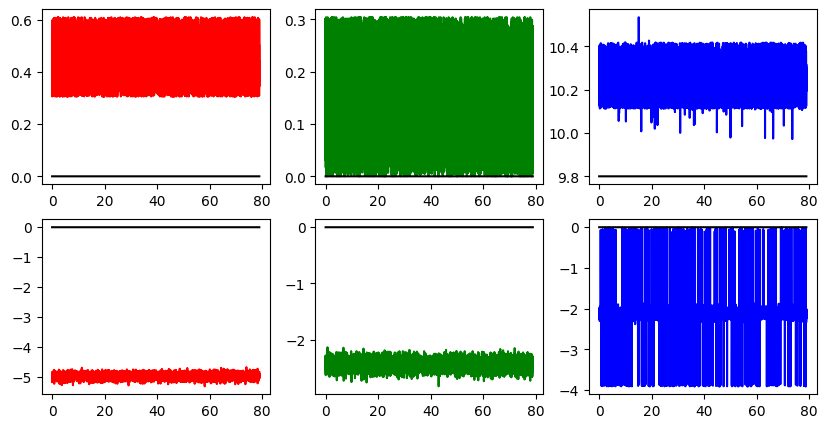

In [4]:
plot_raw(x, [el[1] for el in data])

In [5]:
y = [el[1] for el in data]
apply_bias = True
if apply_bias:
    for device in ['a', 'g']:
        for k in ['x', 'y', 'z']:
            for i in range(len(y)):
                y[i][device][k] = y[i][device][k] + bias[device][k]
# y = [{'a': {'x': el['a']['x'] + bias['a']['x'], 'y': el['a']['y'] + bias['a']['y'], 'z': el['a']['z'] -0.42},
#  'g': {'x': el['g']['x'] +4.97, 'y': el['g']['y'] +2.48857, 'z': el['g']['z'] +2.1388}} for el in y]
# plot_raw(x, y)

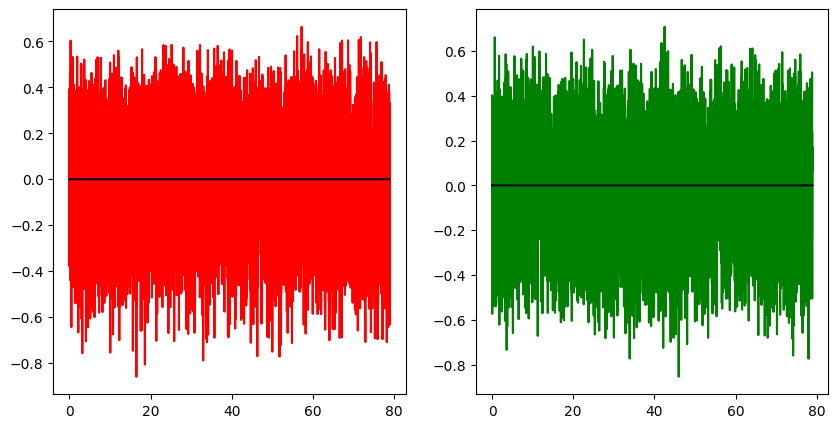

Avg roll:  0.00011817715574166679
Std roll:  0.2163713866911182 

Avg pitch:  -3.984270737277559e-05
Std pitch:  0.21805219080441854 



In [6]:
apply_comp(x, y, sum(tm)/len(tm))

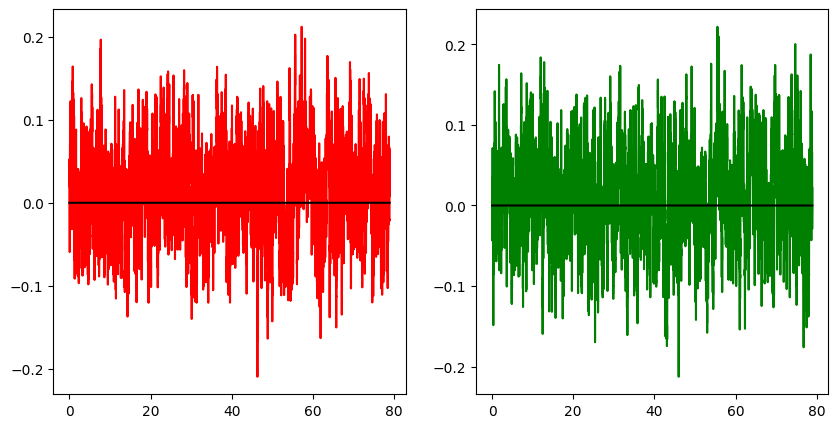

Avg roll:  0.014241348766676836
Std roll:  0.054266189692495116 

Avg pitch:  0.010569129658051209
Std pitch:  0.05823161555997603 



In [7]:
apply_madgwick(x, y, sum(tm)/len(tm))

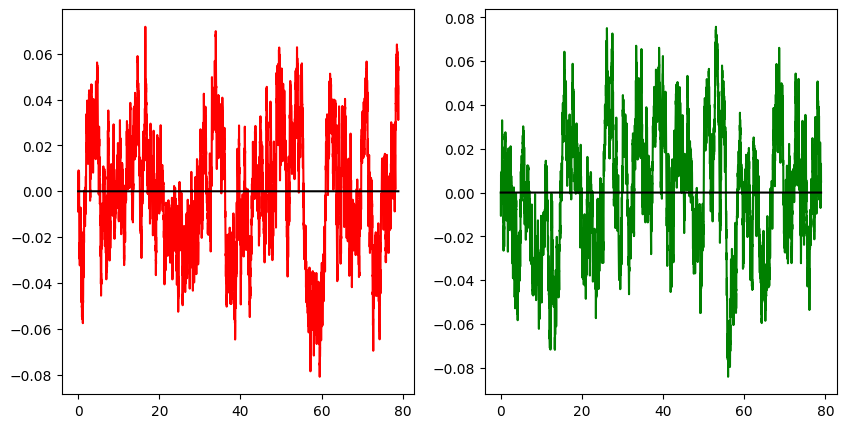

Avg roll:  -0.0006121249999291969
Std roll:  0.02658618234456509 

Avg pitch:  -2.5537696315728804e-05
Std pitch:  0.02876200186819326 



In [8]:
apply_aqua(x, y, sum(tm)/len(tm))